In [1]:
import os
import tensorflow as tf

from tensorflow.keras.models import load_model
from matplotlib.pyplot import imshow
from PIL import Image

from keras_yolo import space_to_depth_x2, space_to_depth_x2_output_shape, yolo_head
from utils import draw_boxes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

input = (m, 608, 608, 3)
output = list of bounding boxes (each is p_c, bx, by, bh, bw, c)
    where 
        p_c = objectness score (confidence that bounding box contains an object)
        c   = class of the object
        bx, by = box's x and y coords
        bh, bw = box height and box width respectively

## anchor boxes
anchor boxes are predefined, fixed size boxes that represent the possible shapes/aspect ratios of objects in an image. We're using 5 anchor boxes per grid cell, which are shared across all 80 classes.

So if we have a 19*19 grid cells, we'll have 5 bounding boxes per cell(of anchor box h/w ratios). aka 1805 total bounding boxes.

## architecture
final feature map/encoding after passing through deep CNN = (m, n_h, n_w, anchors, classes)

our architecture => Image (m, 608, 608, 3) -> Deep CNN -> Encoding (m, 19, 19, 5, 85)
    where 19*19 is our box_grid with 5 anchor boxes of 85(p_c+bx+by+bh+bw+80)

class score = probability that the box contains a certain class (i.e., p_c * c_i; the probability that there is an object p_c times prob that the object is a certain class c_i)

## How yolo works

1. We have a preprocessed image which is passed through a deep cnn
2. We get a final feature map encoding of m, grid_height, grid_width, anchor boxes, classes (possibly one-hot). each grid cell has 5 possible bounding boxes, each with a p_c (box confidence), bx, by, bh, bw, and class probabilities.

3. for each box of each cell, a class score is calculated which is the probability that the box contains a certain class (it is p_c * p_i)
4. Since we have bunch of overlapping boxes, we remove them using non-max supression (NMS). We use Intersection over Union or IoU in NMS.
    * Remove boxes with low confidence scores.
    * For the box with the highest confidence score, compute the Intersection over Union (IoU) with all other boxes. Remove boxes that overlap significantly (IoU ≥ IoU_threshold).
    * Repeat until no more boxes can be removed.
5. After applying NMS, we convert the remaining bounding boxes back to image coordinates, along with their confidence scores and class labels

In [2]:
# converts box preds to bounding box corners
def boxesToCornersCoords(box_xy, box_wh):
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

# boxes = (19, 19, 5, 4) where 4 is bx, by, bh, bw
# box_confidence = (19, 19, 5, 1)
# class_probs = (19, 19, 5, 80)
def filterBoxes(boxes, box_confidence, class_probs, thres=0.6):
    box_scores = box_confidence*class_probs             # (19, 19, 5, 80)
    box_classes = tf.math.argmax(box_scores, axis=-1)   # position of max val
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1)  # max val itself
    filter_mask = box_class_scores >= thres
    scores = tf.boolean_mask(box_class_scores, filter_mask)
    boxes = tf.boolean_mask(boxes, filter_mask)
    classes = tf.boolean_mask(box_classes, filter_mask)
    return scores, boxes, classes

def NMS(scores, boxes, classes, max_boxes=10, iou_thres=0.5):
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_thres)
    scores = tf.gather(params=scores, indices=nms_indices)
    boxes = tf.gather(params=boxes, indices=nms_indices)
    classes = tf.gather(params=classes, indices=nms_indices)
    
    return scores, boxes, classes

In [3]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_thres=.6, iou_thres=.5):
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    boxes = boxesToCornersCoords(box_xy, box_wh)
    
    scores, boxes, classes = filterBoxes(boxes, box_confidence, box_class_probs, score_thres)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = NMS(scores, boxes, classes, max_boxes, iou_thres)
    
    return scores, boxes, classes

In [4]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608)

In [5]:
custom_objects_dict = {
    'space_to_depth_x2': space_to_depth_x2,
    'space_to_depth_x2_output_shape': space_to_depth_x2_output_shape
}
yolo_model = load_model('model_data/yolo_model_complete.h5', custom_objects=custom_objects_dict, compile=False)
# yolo_model.summary()

In [6]:
def predict(image_file):
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    image.save(os.path.join("out", image_file), quality=100)
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for images/test.jpg
car 0.89 (np.int32(366), np.int32(299)) (np.int32(745), np.int32(648))
car 0.80 (np.int32(762), np.int32(282)) (np.int32(942), np.int32(412))
car 0.75 (np.int32(159), np.int32(303)) (np.int32(346), np.int32(440))
car 0.70 (np.int32(947), np.int32(324)) (1280, np.int32(704))
car 0.68 (np.int32(705), np.int32(279)) (np.int32(786), np.int32(351))
bus 0.67 (np.int32(5), np.int32(267)) (np.int32(220), np.int32(407))
car 0.60 (np.int32(925), np.int32(285)) (np.int32(1045), np.int32(374))
car 0.45 (np.int32(336), np.int32(296)) (np.int32(377), np.int32(335))
car 0.38 (np.int32(965), np.int32(273)) (np.int32(1023), np.int32(292))
traffic light 0.35 (np.int32(681), np.int32(195)) (np.int32(692), np.int32(215))


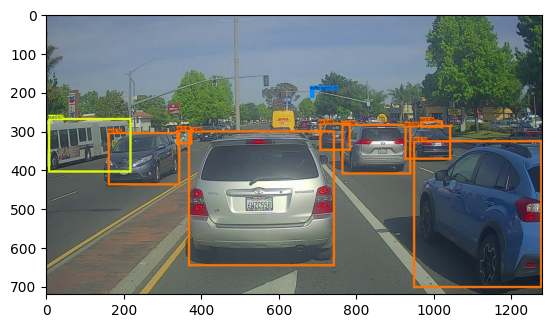

In [7]:
out_scores, out_boxes, out_classes = predict("test.jpg")